In [1]:
!pip install rouge

In [2]:
# Task B - RNN Seq2seq Models for Title Generation
# Natural Language Processing (CS60075) Assignment 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import nltk
from nltk.tokenize import sent_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import time
import re
import os
from rouge import Rouge
import pickle
from tqdm.notebook import tqdm
import random



In [3]:
# Download necessary NLTK packages if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)



In [4]:
# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [5]:
# B1. Setting up a basic RNN Seq2seq model
class ArticleDataset(Dataset):
    def __init__(self, df, tokenizer, max_article_len=500, max_title_len=20):
        self.articles = df['text'].tolist()
        self.titles = df['title'].tolist()
        self.tokenizer = tokenizer
        self.max_article_len = max_article_len
        self.max_title_len = max_title_len
        
    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        article = self.tokenizer.tokenize(self.articles[idx])[:self.max_article_len]
        title = self.tokenizer.tokenize(self.titles[idx])[:self.max_title_len]
        
        # Add special tokens
        title_input = ['<bos>'] + title
        title_target = title + ['<eos>']
        
        return {
            'article': article,
            'title_input': title_input,
            'title_target': title_target
        }



In [6]:
class Tokenizer:
    def __init__(self, min_freq_percent=1):
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<bos>', 3: '<eos>'}
        self.vocab_size = 4  # Start with special tokens
        self.min_freq_percent = min_freq_percent
        
    def build_vocab(self, articles, titles):
        """Build vocabulary from articles and titles based on minimum frequency percentage"""
        total_docs = len(articles)
        min_docs = int(total_docs * self.min_freq_percent / 100)
        
        # Count word frequencies across all documents
        word_counter = Counter()
        for article in articles:
            words = str(article).split()
            word_counter.update(words)
        
        for title in titles:
            words = str(title).split()
            word_counter.update(words)
        
        # Filter by minimum document frequency
        filtered_words = [word for word, count in word_counter.items() if count >= min_docs]
        
        # Add filtered words to vocabulary
        for word in filtered_words:
            if word not in self.word2idx:
                self.word2idx[word] = self.vocab_size
                self.idx2word[self.vocab_size] = word
                self.vocab_size += 1
                
        print(f"Vocabulary size: {self.vocab_size}")
        
    def tokenize(self, text):
        """Split text into tokens"""
        return text.split()
    
    def convert_tokens_to_ids(self, tokens):
        """Convert tokens to indices"""
        return [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]
    
    def convert_ids_to_tokens(self, ids):
        """Convert indices back to tokens"""
        return [self.idx2word.get(idx, '<unk>') for idx in ids]



In [7]:
def collate_fn(batch):
    """Process a batch of data with padding"""
    articles = [item['article'] for item in batch]
    title_inputs = [item['title_input'] for item in batch]
    title_targets = [item['title_target'] for item in batch]
    
    # Get max lengths in this batch
    max_article_len = max(len(article) for article in articles)
    max_title_len = max(len(title) for title in title_inputs)
    
    # Convert tokens to ids
    article_ids = [tokenizer.convert_tokens_to_ids(article) for article in articles]
    title_input_ids = [tokenizer.convert_tokens_to_ids(title) for title in title_inputs]
    title_target_ids = [tokenizer.convert_tokens_to_ids(title) for title in title_targets]
    
    # Pad sequences
    padded_articles = [article + [tokenizer.word2idx['<pad>']] * (max_article_len - len(article)) for article in article_ids]
    padded_title_inputs = [title + [tokenizer.word2idx['<pad>']] * (max_title_len - len(title)) for title in title_input_ids]
    padded_title_targets = [title + [tokenizer.word2idx['<pad>']] * (max_title_len - len(title)) for title in title_target_ids]
    
    # Create attention masks (1 for tokens, 0 for padding)
    article_masks = [[1] * len(article) + [0] * (max_article_len - len(article)) for article in article_ids]
    title_masks = [[1] * len(title) + [0] * (max_title_len - len(title)) for title in title_input_ids]
    
    # Convert to tensors
    article_tensor = torch.tensor(padded_articles, dtype=torch.long)
    title_input_tensor = torch.tensor(padded_title_inputs, dtype=torch.long)
    title_target_tensor = torch.tensor(padded_title_targets, dtype=torch.long)
    article_mask_tensor = torch.tensor(article_masks, dtype=torch.float)
    title_mask_tensor = torch.tensor(title_masks, dtype=torch.float)
    
    return {
        'article_ids': article_tensor,
        'title_input_ids': title_input_tensor,
        'title_target_ids': title_target_tensor,
        'article_mask': article_mask_tensor,
        'title_mask': title_mask_tensor
    }



In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.2, bidirectional=True):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.bidirectional = bidirectional
        self.directions = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True, 
                          bidirectional=bidirectional, dropout=dropout if dropout > 0 else 0)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, mask=None, hidden=None):
        # input_ids: [batch_size, seq_len]
        # mask: [batch_size, seq_len]
        
        embedded = self.dropout(self.embedding(input_ids))  # [batch_size, seq_len, embed_size]
        
        if mask is not None:
            # Apply mask by setting padding to zero
            embedded = embedded * mask.unsqueeze(-1)
            
        outputs, hidden = self.gru(embedded, hidden)
        # outputs: [batch_size, seq_len, hidden_size * directions]
        # hidden: [directions, batch_size, hidden_size]
        
        # If bidirectional, we combine the final forward and backward hidden states
        if self.bidirectional:
            # Combine the last hidden state from both directions
            hidden = hidden.view(self.directions, -1, self.hidden_size)
            hidden = torch.cat([hidden[0], hidden[1]], dim=1).unsqueeze(0)  # [1, batch_size, hidden_size*2]
        
        return outputs, hidden
    
    def load_embeddings(self, embedding_path, word2idx):
        """Load pre-trained GloVe embeddings"""
        print(f"Loading GloVe embeddings from {embedding_path}")
        embeddings_dict = {}
        
        with open(embedding_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading GloVe"):
                values = line.strip().split(' ')
                word = values[0]
                vector = np.array(values[1:], dtype='float32')
                embeddings_dict[word] = vector
        
        # Initialize embedding matrix with random values
        embedding_matrix = np.random.uniform(-0.1, 0.1, (len(word2idx), self.embed_size))
        
        # Update with pretrained embeddings
        found = 0
        for word, idx in word2idx.items():
            if word in embeddings_dict:
                embedding_matrix[idx] = embeddings_dict[word]
                found += 1
        
        print(f"Found {found}/{len(word2idx)} words in GloVe")
        
        # Load into the embedding layer
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        print("GloVe embeddings loaded successfully")



In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.2):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True, dropout=dropout if dropout > 0 else 0)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, hidden):
        # input_ids: [batch_size, 1]
        # hidden: [1, batch_size, hidden_size]
        
        
        embedded = self.dropout(self.embedding(input_ids))  # [batch_size, 1, embed_size]
        embedded = embedded.squeeze(2)
        
        # Passing embedded input and hidden state through GRU
        output, hidden = self.gru(embedded, hidden)
        # output: [batch_size, 1, hidden_size]
        # hidden: [1, batch_size, hidden_size]
        
        # Pass through final linear layer to get logits
        output = self.fc_out(output)  # [batch_size, 1, vocab_size]
        
        return output, hidden



In [10]:
class Decoder2RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.2):
        super(Decoder2RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.gru1 = nn.GRU(embed_size, hidden_size, batch_first=True, dropout=dropout if dropout > 0 else 0)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=dropout if dropout > 0 else 0)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, hidden):
        # input_ids: [batch_size, 1]
        # hidden: tuple of ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
        
        hidden1, hidden2 = hidden
        
        embedded = self.dropout(self.embedding(input_ids))  # [batch_size, 1, embed_size]
        embedded = embedded.squeeze(2)
        
        # First GRU layer
        output1, hidden1 = self.gru1(embedded, hidden1)
        # output1: [batch_size, 1, hidden_size]
        
        # Second GRU layer
        output2, hidden2 = self.gru2(output1, hidden2)
        # output2: [batch_size, 1, hidden_size]
        
        # Pass through final linear layer to get logits
        output = self.fc_out(output2)  # [batch_size, 1, vocab_size]
        
        return output, (hidden1, hidden2)



In [11]:
class HierEncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.2):
        super(HierEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        
        # Word-level components
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.word_gru = nn.GRU(embed_size, hidden_size, batch_first=True, 
                              bidirectional=True, dropout=dropout if dropout > 0 else 0)
        
        # Sentence-level components
        self.sent_gru = nn.GRU(hidden_size*2, hidden_size, batch_first=True, 
                              bidirectional=True, dropout=dropout if dropout > 0 else 0)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, mask=None):
        # input_ids: [batch_size, seq_len]
        # mask: [batch_size, seq_len]
        
        batch_size = input_ids.size(0)
        
        # Process each article hierarchically
        final_outputs = []
        final_hiddens = []
        
        for i in range(batch_size):
            article = input_ids[i]  # [seq_len]
            article_mask = mask[i] if mask is not None else None  # [seq_len]
            
            # Find sentence boundaries (use '<pad>' tokens as separator or split by a max length)
            # This is a simple approximation - in practice, you would use proper sentence tokenization
            sentences = []
            sentence = []
            
            for j, token_id in enumerate(article):
                if token_id.item() == 0:  # '<pad>' token
                    if sentence:  # If not empty
                        sentences.append(sentence)
                        sentence = []
                    break
                else:
                    sentence.append(token_id.item())
                    
                    # Split sentence if it gets too long
                    if len(sentence) >= 30:  # arbitrary max sentence length
                        sentences.append(sentence)
                        sentence = []
            
            if sentence:  # Add the last sentence if not empty
                sentences.append(sentence)
                
            if not sentences:  # If no sentences found (unlikely)
                sentences = [[1]]  # Add an <unk> token
                
            # Process each sentence through word-level GRU
            sentence_embeddings = []
            for sentence in sentences:
                # Convert sentence back to tensor
                sent_tensor = torch.tensor(sentence, device=device).unsqueeze(0)  # [1, sent_len]
                
                # Embed words
                embedded = self.dropout(self.embedding(sent_tensor))  # [1, sent_len, embed_size]
                
                # Process through word-level GRU
                word_outputs, word_hidden = self.word_gru(embedded)
                # word_outputs: [1, sent_len, hidden_size*2]
                # word_hidden: [2, 1, hidden_size]
                
                # Average word-level outputs to get sentence representation
                sent_embedding = word_outputs.mean(dim=1)  # [1, hidden_size*2]
                sentence_embeddings.append(sent_embedding)
            
            # Combine sentence embeddings for the article
            if sentence_embeddings:
                article_embedding = torch.cat(sentence_embeddings, dim=0)  # [num_sentences, hidden_size*2]
                
                # Process through sentence-level GRU
                sent_outputs, sent_hidden = self.sent_gru(article_embedding.unsqueeze(0))
                # sent_outputs: [1, num_sentences, hidden_size*2]
                # sent_hidden: [2, 1, hidden_size]
                
                # Combine directions for the final hidden state
                final_hidden = torch.cat([sent_hidden[0], sent_hidden[1]], dim=1)  # [1, hidden_size*2]
                final_hiddens.append(final_hidden)
            else:
                # Fallback for empty articles (unlikely)
                dummy_hidden = torch.zeros(1, self.hidden_size*2, device=device)
                final_hiddens.append(dummy_hidden)
        
        # Combine all article representations
        combined_hidden = torch.cat(final_hiddens, dim=0)  # [batch_size, hidden_size*2]
        
        # Reshape to match expected encoder output format
        final_hidden = combined_hidden.unsqueeze(0)  # [1, batch_size, hidden_size*2]
        
        return None, final_hidden  # First return value is a placeholder for outputs
    
    def load_embeddings(self, embedding_path, word2idx):
        """Load pre-trained GloVe embeddings"""
        print(f"Loading GloVe embeddings from {embedding_path}")
        embeddings_dict = {}
        
        with open(embedding_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading GloVe"):
                values = line.strip().split(' ')
                word = values[0]
                vector = np.array(values[1:], dtype='float32')
                embeddings_dict[word] = vector
        
        # Initialize embedding matrix with random values
        embedding_matrix = np.random.uniform(-0.1, 0.1, (len(word2idx), self.embed_size))
        
        # Update with pretrained embeddings
        found = 0
        for word, idx in word2idx.items():
            if word in embeddings_dict:
                embedding_matrix[idx] = embeddings_dict[word]
                found += 1
        
        print(f"Found {found}/{len(word2idx)} words in GloVe")
        
        # Load into the embedding layer
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        print("GloVe embeddings loaded successfully")



In [12]:
class Seq2seqRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=300, hidden_size=300, dropout=0.2, 
                 use_glove=False, glove_path=None, 
                 encoder_type='basic', decoder_type='basic'):
        super(Seq2seqRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.encoder_type = encoder_type
        self.decoder_type = decoder_type
        
        # Select encoder based on type
        if encoder_type == 'hierarchical':
            self.encoder = HierEncoderRNN(vocab_size, embed_size, hidden_size, dropout)
        else:  # 'basic'
            self.encoder = EncoderRNN(vocab_size, embed_size, hidden_size, dropout)
        
        # Select decoder based on type
        if decoder_type == 'double':
            self.decoder = Decoder2RNN(vocab_size, embed_size, hidden_size * 2, dropout)
        else:  # 'basic'
            self.decoder = DecoderRNN(vocab_size, embed_size, hidden_size * 2, dropout)
        
        # Load pre-trained GloVe embeddings if requested
        if use_glove and glove_path:
            self.load_embeddings(glove_path)
    
    def load_embeddings(self, glove_path):
        """Load pre-trained GloVe embeddings for both encoder and decoder"""
        # Get word2idx mapping from the tokenizer
        word2idx = tokenizer.word2idx
        
        # Load embeddings into encoder
        self.encoder.load_embeddings(glove_path, word2idx)
        
        # Also load into decoder if it's a standard decoder
        if hasattr(self.decoder, 'embedding'):
            # Copy from encoder to ensure consistency
            self.decoder.embedding.weight.data.copy_(self.encoder.embedding.weight.data)
    
    def forward(self, src, tgt=None, max_len=20, teacher_forcing_ratio=0.5, use_beam_search=False, beam_width=3):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len] (optional, used during training)
        
        batch_size = src.size(0)
        
        # Run the encoder
        encoder_outputs, encoder_hidden = self.encoder(src)
        
        # Initialize decoder input (start with <bos> token)
        decoder_input = torch.ones(batch_size, 1, dtype=torch.long, device=device) * tokenizer.word2idx['<bos>']
        
        # Initialize decoder hidden state with encoder's final hidden state
        if self.decoder_type == 'double':
            # For Decoder2RNN, we need to duplicate the hidden state
            decoder_hidden = (encoder_hidden, encoder_hidden)
        else:
            decoder_hidden = encoder_hidden
        
        # If we're training with teacher forcing (and target is provided)
        if tgt is not None and teacher_forcing_ratio > 0:
            max_len = tgt.size(1)
            outputs = torch.zeros(batch_size, max_len, self.vocab_size, device=device)
            
            for t in range(max_len):
                # Forward pass through decoder
                if self.decoder_type == 'double':
                    decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                else:
                    decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                
                # Store prediction
                outputs[:, t:t+1, :] = decoder_output
                
                # Teacher forcing: use actual target as next input
                use_teacher_forcing = random.random() < teacher_forcing_ratio
                if use_teacher_forcing and t < tgt.size(1) - 1:
                    decoder_input = tgt[:, t+1:t+2]
                else:
                    # Use top predicted token
                    topv, topi = decoder_output.topk(1)
                    decoder_input = topi.detach()  # detach from history as input
            
            return outputs
        
        # If we're in evaluation mode or no target provided
        else:
            # If using beam search
            if use_beam_search:
                return self._beam_search_decode(decoder_input, decoder_hidden, max_len, beam_width)
            # If using greedy search
            else:
                return self._greedy_decode(decoder_input, decoder_hidden, max_len)
    
    def _greedy_decode(self, decoder_input, decoder_hidden, max_len):
        """Greedy decoding for evaluation"""
        batch_size = decoder_input.size(0)
        decoded_outputs = torch.zeros(batch_size, max_len, self.vocab_size, device=device)
        decoded_tokens = []
        
        eos_token_id = tokenizer.word2idx['<eos>']
        
        for t in range(max_len):
            # Forward pass through decoder
            if self.decoder_type == 'double':
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            else:
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            # Store prediction
            decoded_outputs[:, t:t+1, :] = decoder_output
            
            # Get most likely token
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()  # Use as next input
            
            # Convert to tokens and store
            tokens = [tokenizer.idx2word[idx.item()] for idx in topi.squeeze(1)]
            decoded_tokens.append(tokens)
            
            # Stop if all sequences have generated <eos>
            if all(idx.item() == eos_token_id for idx in topi.squeeze(1)):
                break
        
        # Transpose to get sequences for each batch item
        decoded_tokens = list(zip(*decoded_tokens))
        
        # Convert to list of lists and trim after EOS
        final_tokens = []
        for seq in decoded_tokens:
            if '<eos>' in seq:
                eos_idx = seq.index('<eos>')
                seq = seq[:eos_idx+1]
            final_tokens.append(list(seq))
        
        return decoded_outputs, final_tokens
    
    def _beam_search_decode(self, decoder_input, decoder_hidden, max_len, beam_width=3):
        """Beam search decoding for evaluation"""
        batch_size = decoder_input.size(0)
        
        # We'll handle beam search independently for each item in the batch
        all_decoded_tokens = []
        
        # For storing outputs (for consistency with greedy decode API)
        dummy_outputs = torch.zeros(batch_size, max_len, self.vocab_size, device=device)
        
        # Process each batch item separately
        for b in range(batch_size):
            # Extract single input and hidden state for this batch item
            if self.decoder_type == 'double':
                single_hidden = (decoder_hidden[0][:, b:b+1, :], decoder_hidden[1][:, b:b+1, :])
            else:
                single_hidden = decoder_hidden[:, b:b+1, :]
                
            single_input = decoder_input[b:b+1, :]
            
            # Initialize beam
            beams = [(0, single_input, single_hidden, ['<bos>'])]  # (score, input, hidden, tokens)
            completed_beams = []
            
            # Expand beams for max_len steps
            for _ in range(max_len):
                new_beams = []
                
                for score, input_ids, hidden, tokens in beams:
                    # If last token is EOS, add to completed beams
                    if tokens[-1] == '<eos>':
                        completed_beams.append((score, tokens))
                        continue
                    
                    # Forward pass through decoder
                    if self.decoder_type == 'double':
                        output, new_hidden = self.decoder(input_ids, hidden)
                    else:
                        output, new_hidden = self.decoder(input_ids, hidden)
                    
                    # Get top-k tokens
                    probs = F.log_softmax(output.squeeze(1), dim=-1)
                    topk_probs, topk_ids = probs.topk(beam_width)
                    
                    # Create new beam candidates
                    for i in range(beam_width):
                        new_score = score + topk_probs[0, i].item()
                        new_token_id = topk_ids[0, i].unsqueeze(0).unsqueeze(0)
                        new_token = tokenizer.idx2word[topk_ids[0, i].item()]
                        
                        new_beams.append((
                            new_score,
                            new_token_id,
                            new_hidden,
                            tokens + [new_token]
                        ))
                
                # Keep only the top beam_width candidates
                beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]
                
                # Check if all beams end with EOS
                if all(beam[3][-1] == '<eos>' for beam in beams):
                    break
            
            # Add any remaining beams to completed
            for score, _, _, tokens in beams:
                if tokens[-1] != '<eos>':
                    tokens.append('<eos>')
                completed_beams.append((score, tokens))
            
            # Get the best sequence
            best_beam = sorted(completed_beams, key=lambda x: x[0], reverse=True)[0]
            all_decoded_tokens.append(best_beam[1])
        
        return dummy_outputs, all_decoded_tokens



In [23]:
def tune_hyperparameters(param_grid, train_dataset, val_dataset, tokenizer, n_trials=10):
    """
    Perform random search hyperparameter tuning
    
    Args:
        param_grid: Dictionary of hyperparameter ranges
        train_dataset: Training dataset
        val_dataset: Validation dataset
        tokenizer: Tokenizer object
        n_trials: Number of random trials to perform
        
    Returns:
        best_params: Best hyperparameters found
        best_val_loss: Best validation loss achieved
    """
    import random
    
    results = []
    best_val_loss = float('inf')
    best_params = None
    
    # Create a smaller subset of data for faster tuning
    train_subset = torch.utils.data.Subset(train_dataset, 
                                          indices=random.sample(range(len(train_dataset)), 
                                                               min(2000, len(train_dataset))))
    val_subset = torch.utils.data.Subset(val_dataset, 
                                        indices=random.sample(range(len(val_dataset)), 
                                                             min(500, len(val_dataset))))
    
    print(f"Starting hyperparameter tuning with {n_trials} trials...")
    
    for trial in range(n_trials):
        # Sample random hyperparameters
        params = {
            'batch_size': random.choice(param_grid['batch_size']),
            'embed_size': random.choice(param_grid['embed_size']),
            'hidden_size': random.choice(param_grid['hidden_size']),
            'learning_rate': random.choice(param_grid['learning_rate']),
            'dropout': random.choice(param_grid['dropout']),
            'teacher_forcing_ratio': random.choice(param_grid['teacher_forcing_ratio'])
        }
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print(f"Parameters: {params}")
        
        # Create dataloaders with the current batch size
        train_loader = DataLoader(train_subset, batch_size=params['batch_size'], 
                                 shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_subset, batch_size=params['batch_size'], 
                               collate_fn=collate_fn)
        
        # Initialize model with current hyperparameters
        model = Seq2seqRNN(
            vocab_size=tokenizer.vocab_size,
            embed_size=params['embed_size'],
            hidden_size=params['hidden_size'],
            dropout=params['dropout']
        ).to(device)
        
        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<pad>'])
        
        # Train for a few epochs
        train_losses = []
        val_losses = []
        
        for epoch in range(2):  # Use fewer epochs for tuning
            # Train
            train_loss = train_epoch(model, train_loader, optimizer, criterion, 
                                    params['teacher_forcing_ratio'])
            train_losses.append(train_loss)
            
            # Evaluate
            val_loss = evaluate(model, val_loader, criterion)
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}/2 - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Record the results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'val_loss': final_val_loss
        })
        
        # Update best parameters if needed
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params
            print(f"New best validation loss: {best_val_loss:.4f}")
    
    print("\nHyperparameter tuning completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best parameters: {best_params}")
    
    return best_params, best_val_loss


In [26]:
# Training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        # Move data to device
        src = batch['article_ids'].to(device)
        tgt = batch['title_input_ids'].to(device)
        tgt_y = batch['title_target_ids'].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt, teacher_forcing_ratio=teacher_forcing_ratio)
        
        # Reshape output and target for loss calculation
        # output: [batch_size, tgt_len, vocab_size]
        # tgt_y: [batch_size, tgt_len]
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt_y = tgt_y.contiguous().view(-1)
        
        # Calculate loss (ignore padding)
        loss = criterion(output, tgt_y)
        
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)



In [25]:
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move tensors to device - using the correct keys from your batch
            src = batch['article_ids'].to(device)
            tgt = batch['title_input_ids'].to(device)  # Input for decoder
            tgt_y = batch['title_target_ids'].to(device)  # Target for loss calculation
            
            # Forward pass
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            
            # Check if output is a tuple and extract the predictions
            if isinstance(output, tuple):
                output = output[0]
            
            # Get the shapes for debugging
            #print(f"Output shape before reshape: {output.shape}")
           # print(f"Target shape before reshape: {tgt_y.shape}")
            
            # Make sure the reshaping maintains the same number of elements
            batch_size = tgt_y.size(0)
            output_dim = output.shape[-1]
            seq_len = tgt_y.size(1)
            
            # Reshape output to match the expected format for loss calculation
            # The reshaped output should have shape: [batch_size * seq_len, output_dim]
            output = output[:, :seq_len, :].contiguous().view(-1, output_dim)
            
            # Reshape target to have shape: [batch_size * seq_len]
            tgt_y = tgt_y.contiguous().view(-1)
            
            # Print shapes after reshaping for verification
            #print(f"Output shape after reshape: {output.shape}")
            #print(f"Target shape after reshape: {tgt_y.shape}")
            
            # Calculate loss
            loss = criterion(output, tgt_y)
            epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

In [16]:
def generate_titles(model, dataloader, use_beam_search=False, beam_width=3):
    model.eval()
    generated_titles = []
    reference_titles = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating"):
            # Move data to device
            src = batch['article_ids'].to(device)
            
            # Improved reference title extraction
            for ids in batch['title_target_ids']:
                tokens = []
                for id in ids.tolist():
                    token = tokenizer.idx2word.get(id, '<unk>')
                    if token == '<pad>' or token == '<eos>':
                        break
                    if token != '<bos>':  # Skip beginning of sentence token
                        tokens.append(token)
                reference_titles.append(' '.join(tokens))
            
            # Generate titles
            _, decoded_tokens = model(src, max_len=20, use_beam_search=use_beam_search, beam_width=beam_width)
            
            # Convert token lists to strings, removing BOS and EOS tokens
            for tokens in decoded_tokens:
                if '<bos>' in tokens:
                    tokens.remove('<bos>')
                if '<eos>' in tokens:
                    tokens = tokens[:tokens.index('<eos>')]
                
                generated_titles.append(' '.join(tokens))
    
    return generated_titles, reference_titles

In [17]:

def calculate_rouge_scores(hypotheses, references):
    """Calculate ROUGE scores between generated and reference titles"""
    rouge = Rouge()
    
    # Ensure no empty strings (ROUGE doesn't handle them well)
    valid_pairs = [(hyp, ref) for hyp, ref in zip(hypotheses, references) 
                   if len(hyp.strip()) > 0 and len(ref.strip()) > 0]
    
    if not valid_pairs:
        return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}
    
    valid_hyps, valid_refs = zip(*valid_pairs)
    
    try:
        scores = rouge.get_scores(valid_hyps, valid_refs, avg=True)
        return scores
    except Exception as e:
        print(f"Error calculating ROUGE: {e}")
        # Return zero scores in case of error
        return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}



In [18]:
def plot_training_history(train_losses, val_losses, save_path=None):
    """Plot training and validation losses"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()



In [19]:

# Load preprocessed data
print("Loading datasets...")
train_df = pd.read_csv('/kaggle/input/hello-finalc/train_preprocessed.csv')
val_df = pd.read_csv('/kaggle/input/hello-finalc/val_preprocessed.csv')
test_df = pd.read_csv('/kaggle/input/hello-finalc/test_preprocessed.csv')

print(f"Train set: {len(train_df)} articles")
print(f"Validation set: {len(val_df)} articles")
print(f"Test set: {len(test_df)} articles")



Loading datasets...
Train set: 13379 articles
Validation set: 500 articles
Test set: 100 articles


In [20]:
# Initialize tokenizer and build vocabulary
print("Building vocabulary...")
tokenizer = Tokenizer(min_freq_percent=0)
tokenizer.build_vocab(train_df['lem_text'].tolist(), train_df['lem_title'].tolist())
tokenizer.build_vocab(val_df['lem_text'].tolist(), val_df['lem_title'].tolist())
tokenizer.build_vocab(test_df['lem_text'].tolist(), test_df['lem_title'].tolist())




Building vocabulary...
Vocabulary size: 104240
Vocabulary size: 106667
Vocabulary size: 107103


In [21]:
# Create datasets and dataloaders
print("Creating datasets...")
train_dataset = ArticleDataset(train_df, tokenizer)
val_dataset = ArticleDataset(val_df, tokenizer)
test_dataset = ArticleDataset(test_df, tokenizer)




Creating datasets...


In [45]:
# Hyperparameters
# BATCH_SIZE = 32
# EMBED_SIZE = 300
# HIDDEN_SIZE = 300
# LEARNING_RATE = 0.001
# NUM_EPOCHS = 5
# TEACHER_FORCING_RATIO = 0.8
# DROPOUT = 0.2



# Define hyperparameter search space
param_grid = {
    'batch_size': [16,32, 64],
    'embed_size': [300],
    'hidden_size': [300],
    'learning_rate': [0.0001, 0.001, 0.01],
    'dropout': [0.1,0.3,0.5],
    'teacher_forcing_ratio': [0.5, 0.7,0.9]
}


# Run hyperparameter tuning
best_params, best_val_loss = tune_hyperparameters(
    param_grid=param_grid,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    n_trials=5
)


# Print best parameters
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Starting hyperparameter tuning with 5 trials...

Trial 1/5
Parameters: {'batch_size': 32, 'embed_size': 300, 'hidden_size': 300, 'learning_rate': 0.001, 'dropout': 0.3, 'teacher_forcing_ratio': 0.9}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 6.7083, Val Loss: 6.8624


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/2 - Train Loss: 4.1070, Val Loss: 6.2503
New best validation loss: 6.2503

Trial 2/5
Parameters: {'batch_size': 16, 'embed_size': 300, 'hidden_size': 300, 'learning_rate': 0.01, 'dropout': 0.5, 'teacher_forcing_ratio': 0.9}


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 7.0211, Val Loss: 6.9516


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/2 - Train Loss: 4.4657, Val Loss: 8.8057

Trial 3/5
Parameters: {'batch_size': 32, 'embed_size': 300, 'hidden_size': 300, 'learning_rate': 0.01, 'dropout': 0.3, 'teacher_forcing_ratio': 0.9}


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 6.6927, Val Loss: 7.0091


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/2 - Train Loss: 3.6132, Val Loss: 7.9973

Trial 4/5
Parameters: {'batch_size': 16, 'embed_size': 300, 'hidden_size': 300, 'learning_rate': 0.01, 'dropout': 0.1, 'teacher_forcing_ratio': 0.5}


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 7.3429, Val Loss: 7.9821


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/2 - Train Loss: 5.4359, Val Loss: 8.3988

Trial 5/5
Parameters: {'batch_size': 32, 'embed_size': 300, 'hidden_size': 300, 'learning_rate': 0.01, 'dropout': 0.5, 'teacher_forcing_ratio': 0.9}


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 6.7162, Val Loss: 6.9371


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/2 - Train Loss: 4.0717, Val Loss: 8.3922

Hyperparameter tuning completed!
Best validation loss: 6.2503
Best parameters: {'batch_size': 32, 'embed_size': 300, 'hidden_size': 300, 'learning_rate': 0.001, 'dropout': 0.3, 'teacher_forcing_ratio': 0.9}

Best Hyperparameters:
batch_size: 32
embed_size: 300
hidden_size: 300
learning_rate: 0.001
dropout: 0.3
teacher_forcing_ratio: 0.9


In [46]:
# Create dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Train final model with best hyperparameters
print("\nTraining final model with best hyperparameters...")

# Create dataloaders with the best batch size
final_train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], 
                                   shuffle=True, collate_fn=collate_fn)
final_val_dataloader = DataLoader(val_dataset, batch_size=best_params['batch_size'], 
                                 collate_fn=collate_fn)
final_test_dataloader = DataLoader(test_dataset, batch_size=best_params['batch_size'], 
                                  collate_fn=collate_fn)


Training final model with best hyperparameters...


In [47]:
# Initialize the model
print("Initializing model...")
# Initialize the final model
final_model = Seq2seqRNN(
    vocab_size=tokenizer.vocab_size,
    embed_size=best_params['embed_size'],
    hidden_size=best_params['hidden_size'],
    dropout=best_params['dropout']
).to(device)
# model = Seq2seqRNN(
#     vocab_size=tokenizer.vocab_size,
#     embed_size=EMBED_SIZE,
#     hidden_size=HIDDEN_SIZE,
#     dropout=DROPOUT
# ).to(device)
# Define optimizer and loss function
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
final_criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<pad>'])
# Define optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Ignore padding index in loss calculation
# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<pad>'])

NUM_EPOCHS=5

Initializing model...


In [48]:
# Train for the full number of epochs
print("started training")
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(final_model, final_train_dataloader, final_optimizer, 
                            final_criterion, best_params['teacher_forcing_ratio'])
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(final_model, final_val_dataloader, final_criterion)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(final_model.state_dict(), 'basic_rnn_best_model.pt')
        print("Saved best model")



started training
Epoch 1/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 5.3068


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.2050
Saved best model
Epoch 2/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 3.3136


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.1114
Saved best model
Epoch 3/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 2.0560


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.2096
Epoch 4/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 0.9996


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.4155
Epoch 5/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 0.4609


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.5482


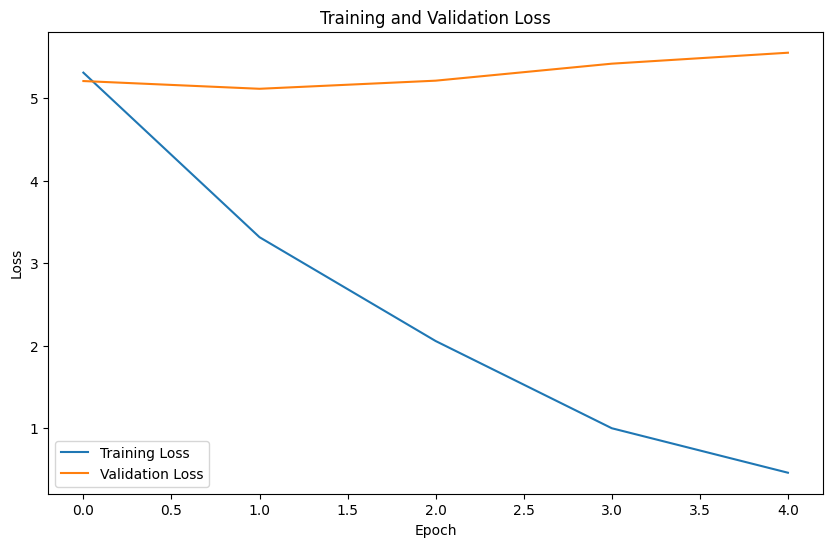

/tmp/ipykernel_31/2963883311.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('basic_rnn_best_model.pt'))


<All keys matched successfully>

In [49]:
# Plot training history
plot_training_history(train_losses, val_losses, 'training_history.png')

# Load the best model
final_model.load_state_dict(torch.load('basic_rnn_best_model.pt'))



In [50]:
# Generate titles with the tuned model
print("Generating titles with tuned model...")
tuned_gen_titles, tuned_ref_titles = generate_titles(final_model, final_test_dataloader)

# Calculate ROUGE scores
print("Calculating ROUGE scores for tuned model...")
tuned_rouge_scores = calculate_rouge_scores(tuned_gen_titles, tuned_ref_titles)

print("Tuned Model ROUGE-1 F1:", tuned_rouge_scores['rouge-1']['f'])
print("Tuned Model ROUGE-2 F1:", tuned_rouge_scores['rouge-2']['f'])
print("Tuned Model ROUGE-L F1:", tuned_rouge_scores['rouge-l']['f'])

# Save results
tuned_results = pd.DataFrame({
    'Reference': tuned_ref_titles,
    'Generated': tuned_gen_titles
})
tuned_results.to_csv('tuned_model_results.csv', index=False)


Generating titles with tuned model...


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating ROUGE scores for tuned model...
Tuned Model ROUGE-1 F1: 0.3590634892115596
Tuned Model ROUGE-2 F1: 0.08699999931711112
Tuned Model ROUGE-L F1: 0.3590634892115596


In [51]:
print(tuned_results)

                              Reference  \
0                               Weyburn   
1         Catholic High <unk> Singapore   
2              Minnesota Golden Gophers   
3         List of people from Louisiana   
4                              Theobald   
..                                  ...   
95  Kutztown University of Pennsylvania   
96                          Bear Bryant   
97                     Jonathan Spector   
98                           Abia State   
99                 Table <unk> Nebraska   

                                    Generated  
0                                       <unk>  
1   High School High School <unk> <unk> <unk>  
2                                 The Raiders  
3                   List of people from <unk>  
4                                      Ernest  
..                                        ...  
95               University of North Carolina  
96                            Paul Paul <unk>  
97                          Jonathan Jonathan  
98 

In [52]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-04-15 16:18:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-15 16:18:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-15 16:18:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [57]:
# List of files to delete
files_to_delete = [
    '/kaggle/working/glove.6B.100d.txt',
    '/kaggle/working/glove.6B.200d.txt',
    '/kaggle/working/glove.6B.50d.txt',
    '/kaggle/working/glove.6B.zip'
]

for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_path} deleted.")
    else:
        print(f"{file_path} does not exist.")


/kaggle/working/glove.6B.100d.txt does not exist.
/kaggle/working/glove.6B.200d.txt does not exist.
/kaggle/working/glove.6B.50d.txt does not exist.
/kaggle/working/glove.6B.zip does not exist.


In [58]:
# B2. Improving the RNN model
# Test with GloVe embeddings
print("\nTraining model with GloVe embeddings...")

# Path to GloVe embeddings
glove_path = '/kaggle/working/glove.6B.300d.txt'




Training model with GloVe embeddings...


In [59]:
# Initialize model with GloVe
model_glove = Seq2seqRNN(
    vocab_size=tokenizer.vocab_size,
    embed_size=param_grid['embed_size'][0],
    hidden_size=param_grid['hidden_size'][0],
    dropout=param_grid['dropout'][0],
    use_glove=True,
    glove_path=glove_path
).to(device)



Loading GloVe embeddings from /kaggle/working/glove.6B.300d.txt


Loading GloVe: 0it [00:00, ?it/s]

Found 14073/107103 words in GloVe
GloVe embeddings loaded successfully


In [64]:
# Train with GloVe
optimizer = optim.Adam(model_glove.parameters(), lr=param_grid['learning_rate'][0])
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<pad>'])
train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model_glove, final_train_dataloader, optimizer, criterion, best_params['teacher_forcing_ratio'])
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(model_glove, final_val_dataloader, criterion)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_glove.state_dict(), 'best_model_glove.pt')
        print("Saved best model")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Load best GloVe model
model_glove.load_state_dict(torch.load('best_model_glove.pt'))



Epoch 1/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 6.5207


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 7.0699
Saved best model
Epoch 2/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 4.9512


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 6.5720
Saved best model
Epoch 3/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 4.5567


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 6.0627
Saved best model
Epoch 4/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 4.2830


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.9388
Saved best model
Epoch 5/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 4.0809


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.9054
Saved best model
Training completed in 387.52 seconds


/tmp/ipykernel_31/2054080859.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_glove.load_state_dict(torch.load('best_model_glove.pt'))


<All keys matched successfully>

In [67]:
# Generate titles with GloVe
print("Generating titles with GloVe and greedy search...")
gen_titles_glove, ref_titles = generate_titles(model_glove, final_test_dataloader, use_beam_search=False)

# Calculate ROUGE scores
rouge_scores_glove = calculate_rouge_scores(gen_titles_glove, ref_titles)

print("ROUGE-1 F1:", rouge_scores_glove['rouge-1']['f'])
print("ROUGE-2 F1:", rouge_scores_glove['rouge-2']['f'])
print("ROUGE-L F1:", rouge_scores_glove['rouge-l']['f'])



Generating titles with GloVe and greedy search...


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

ROUGE-1 F1: 0.22743650593191617
ROUGE-2 F1: 0.05841269793038548
ROUGE-L F1: 0.22743650593191617


In [69]:
# Train hierarchical encoder model
print("\nTraining hierarchical encoder model...")

# Initialize model with hierarchical encoder
model_hier = Seq2seqRNN(
    vocab_size=tokenizer.vocab_size,
    embed_size=param_grid['embed_size'][0],
    hidden_size=param_grid['hidden_size'][0],
    dropout=param_grid['dropout'][0],
    encoder_type='hierarchical'
).to(device)




Training hierarchical encoder model...


In [74]:
# Train with hierarchical encoder
optimizer = optim.Adam(model_hier.parameters(), lr=param_grid['learning_rate'][0])

train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()
NUM_EPOCHS=1
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model_hier, final_train_dataloader, optimizer, criterion, best_params['teacher_forcing_ratio'])
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(model_hier, final_val_dataloader, criterion)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_hier.state_dict(), 'best_model_hier.pt')
        print("Saved best model")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Load best hierarchical model
model_hier.load_state_dict(torch.load('best_model_hier.pt'))




Epoch 1/1


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 5.0843


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 6.0252
Saved best model
Training completed in 1027.72 seconds


/tmp/ipykernel_31/1284264562.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_hier.load_state_dict(torch.load('best_model_hier.pt'))


<All keys matched successfully>

In [76]:
# Generate titles with hierarchical encoder
print("Generating titles with hierarchical encoder and greedy search...")
gen_titles_hier, ref_titles = generate_titles(model_hier, final_test_dataloader, use_beam_search=False)

# Calculate ROUGE scores
rouge_scores_hier = calculate_rouge_scores(gen_titles_hier, ref_titles)

print("ROUGE-1 F1:", rouge_scores_hier['rouge-1']['f'])
print("ROUGE-2 F1:", rouge_scores_hier['rouge-2']['f'])
print("ROUGE-L F1:", rouge_scores_hier['rouge-l']['f'])



Generating titles with hierarchical encoder and greedy search...


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

ROUGE-1 F1: 0.20591269693533987
ROUGE-2 F1: 0.028571428422448985
ROUGE-L F1: 0.20591269693533987


In [79]:
# Train double decoder model
print("\nTraining double decoder model...")

# Initialize model with double decoder
model_double = Seq2seqRNN(
    vocab_size=tokenizer.vocab_size,
    embed_size=param_grid['embed_size'][0],
    hidden_size=param_grid['hidden_size'][0],
    dropout=param_grid['dropout'][0],
    decoder_type='double'
).to(device)

# Train with double decoder
optimizer = optim.Adam(model_double.parameters(), lr=param_grid['learning_rate'][0])

train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()
NUM_EPOCHS=5
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model_double, final_train_dataloader, optimizer, criterion, best_params['teacher_forcing_ratio'])
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(model_double, final_val_dataloader, criterion)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_double.state_dict(), 'best_model_double.pt')
        print("Saved best model")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Load best double decoder model
model_double.load_state_dict(torch.load('best_model_double.pt'))




Training double decoder model...
Epoch 1/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 6.2588


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 6.1066
Saved best model
Epoch 2/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 4.6241


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.7258
Saved best model
Epoch 3/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 4.1343


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.5807
Saved best model
Epoch 4/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 3.8209


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.5282
Saved best model
Epoch 5/5


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 3.5738


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 5.5065
Saved best model
Training completed in 395.52 seconds


/tmp/ipykernel_31/1432662097.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_double.load_state_dict(torch.load('best_model_double.pt'))


<All keys matched successfully>

In [80]:
# Generate titles with double decoder
print("Generating titles with double decoder and greedy search...")
gen_titles_double, ref_titles = generate_titles(model_double, final_test_dataloader, use_beam_search=False)

# Calculate ROUGE scores
rouge_scores_double = calculate_rouge_scores(gen_titles_double, ref_titles)

print("ROUGE-1 F1:", rouge_scores_double['rouge-1']['f'])
print("ROUGE-2 F1:", rouge_scores_double['rouge-2']['f'])
print("ROUGE-L F1:", rouge_scores_double['rouge-l']['f'])



Generating titles with double decoder and greedy search...


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

ROUGE-1 F1: 0.30373592813629297
ROUGE-2 F1: 0.06204040349605184
ROUGE-L F1: 0.30373592813629297


In [82]:
# Generate titles with beam search for best model
print("\nGenerating titles with beam search...")

# Load the overall best model (choose based on validation performance)
best_model = final_model  # Default to basic model
best_model_name = "Basic"
best_val_scores = [best_val_loss]

model_configs = [
    (model_glove, "GloVe", torch.load('best_model_glove.pt')),
    (model_hier, "Hierarchical", torch.load('best_model_hier.pt')),
    (model_double, "Double Decoder", torch.load('best_model_double.pt'))
]

for model_variant, name, state_dict in model_configs:
    model_variant.load_state_dict(state_dict)
    val_loss = evaluate(model_variant, final_val_dataloader, criterion)
    
    if val_loss < min(best_val_scores):
        best_model = model_variant
        best_model_name = name






Generating titles with beam search...


/tmp/ipykernel_31/1342929422.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (model_glove, "GloVe", torch.load('best_model_glove.pt')),
/tmp/ipykernel_31/1342929422.py:

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

In [83]:
print(f"Using {best_model_name} model for beam search generation")
# Generate with beam search
gen_titles_beam, ref_titles = generate_titles(best_model, final_test_dataloader, use_beam_search=True, beam_width=3)

# Calculate ROUGE scores
rouge_scores_beam = calculate_rouge_scores(gen_titles_beam, ref_titles)

print("ROUGE-1 F1:", rouge_scores_beam['rouge-1']['f'])
print("ROUGE-2 F1:", rouge_scores_beam['rouge-2']['f'])
print("ROUGE-L F1:", rouge_scores_beam['rouge-l']['f'])



Using Basic model for beam search generation


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

ROUGE-1 F1: 0.3496190448605392
ROUGE-2 F1: 0.09266666598377778
ROUGE-L F1: 0.3496190448605392


In [87]:
# Train combined best model (all improvements together)
print("\nTraining model with all improvements...")

# Initialize model with all improvements
model_all = Seq2seqRNN(
    vocab_size=tokenizer.vocab_size,
    embed_size=param_grid['embed_size'][0],
    hidden_size=param_grid['hidden_size'][0],
    dropout=param_grid['dropout'][0],
    use_glove=True,
    glove_path=glove_path,
    encoder_type='hierarchical',
    decoder_type='double'
).to(device)

# Train with all improvements
optimizer = optim.Adam(model_all.parameters(), lr=param_grid['learning_rate'][0])

train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()
NUM_EPOCHS=1
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model_all, final_train_dataloader, optimizer, criterion, best_params['teacher_forcing_ratio'])
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(model_all, final_val_dataloader, criterion)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_all.state_dict(), 'best_model_all.pt')
        print("Saved best model")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Load best combined model
model_all.load_state_dict(torch.load('best_model_all.pt'))





Training model with all improvements...
Loading GloVe embeddings from /kaggle/working/glove.6B.300d.txt


Loading GloVe: 0it [00:00, ?it/s]

Found 14073/107103 words in GloVe
GloVe embeddings loaded successfully
Epoch 1/1


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Train Loss: 6.3334


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss: 7.0556
Saved best model
Training completed in 1031.19 seconds


/tmp/ipykernel_31/2104825517.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_all.load_state_dict(torch.load('best_model_all.pt'))


<All keys matched successfully>

In [88]:
# Generate titles with all improvements
print("Generating titles with all improvements (greedy)...")
gen_titles_all, ref_titles = generate_titles(model_all, final_test_dataloader, use_beam_search=False)

# Calculate ROUGE scores
rouge_scores_all = calculate_rouge_scores(gen_titles_all, ref_titles)

print("ROUGE-1 F1:", rouge_scores_all['rouge-1']['f'])
print("ROUGE-2 F1:", rouge_scores_all['rouge-2']['f'])
print("ROUGE-L F1:", rouge_scores_all['rouge-l']['f'])



Generating titles with all improvements (greedy)...


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

ROUGE-1 F1: 0.20919047475059763
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.20919047475059763


In [89]:
# Generate with beam search for all improvements
print("Generating titles with all improvements (beam search)...")
gen_titles_all_beam, ref_titles = generate_titles(model_all, final_test_dataloader, use_beam_search=True, beam_width=3)

# Calculate ROUGE scores
rouge_scores_all_beam = calculate_rouge_scores(gen_titles_all_beam, ref_titles)

print("ROUGE-1 F1:", rouge_scores_all_beam['rouge-1']['f'])
print("ROUGE-2 F1:", rouge_scores_all_beam['rouge-2']['f'])
print("ROUGE-L F1:", rouge_scores_all_beam['rouge-l']['f'])



Generating titles with all improvements (beam search)...


Generating:   0%|          | 0/4 [00:00<?, ?it/s]

ROUGE-1 F1: 0.20919047475059763
ROUGE-2 F1: 0.0
ROUGE-L F1: 0.20919047475059763


In [93]:
# Compile all results
results_dict = {
    'Model': ['Basic (Greedy)', 'GloVe (Greedy)', 'Hierarchical (Greedy)', 
              'Double Decoder (Greedy)', f'{best_model_name} (Beam Search)', 
              'All Improvements (Greedy)', 'All Improvements (Beam Search)'],
    'ROUGE-1': [tuned_rouge_scores['rouge-1']['f'], rouge_scores_glove['rouge-1']['f'],
               rouge_scores_hier['rouge-1']['f'], rouge_scores_double['rouge-1']['f'],
               rouge_scores_beam['rouge-1']['f'], rouge_scores_all['rouge-1']['f'],
               rouge_scores_all_beam['rouge-1']['f']],
    'ROUGE-2': [tuned_rouge_scores['rouge-2']['f'], rouge_scores_glove['rouge-2']['f'],
               rouge_scores_hier['rouge-2']['f'], rouge_scores_double['rouge-2']['f'],
               rouge_scores_beam['rouge-2']['f'], rouge_scores_all['rouge-2']['f'],
               rouge_scores_all_beam['rouge-2']['f']],
    'ROUGE-L': [tuned_rouge_scores['rouge-l']['f'], rouge_scores_glove['rouge-l']['f'],
               rouge_scores_hier['rouge-l']['f'], rouge_scores_double['rouge-l']['f'],
               rouge_scores_beam['rouge-l']['f'], rouge_scores_all['rouge-l']['f'],
               rouge_scores_all_beam['rouge-l']['f']]
}



In [94]:
results_df = pd.DataFrame(results_dict)
results_df.to_csv('all_models_rouge_results.csv', index=False)



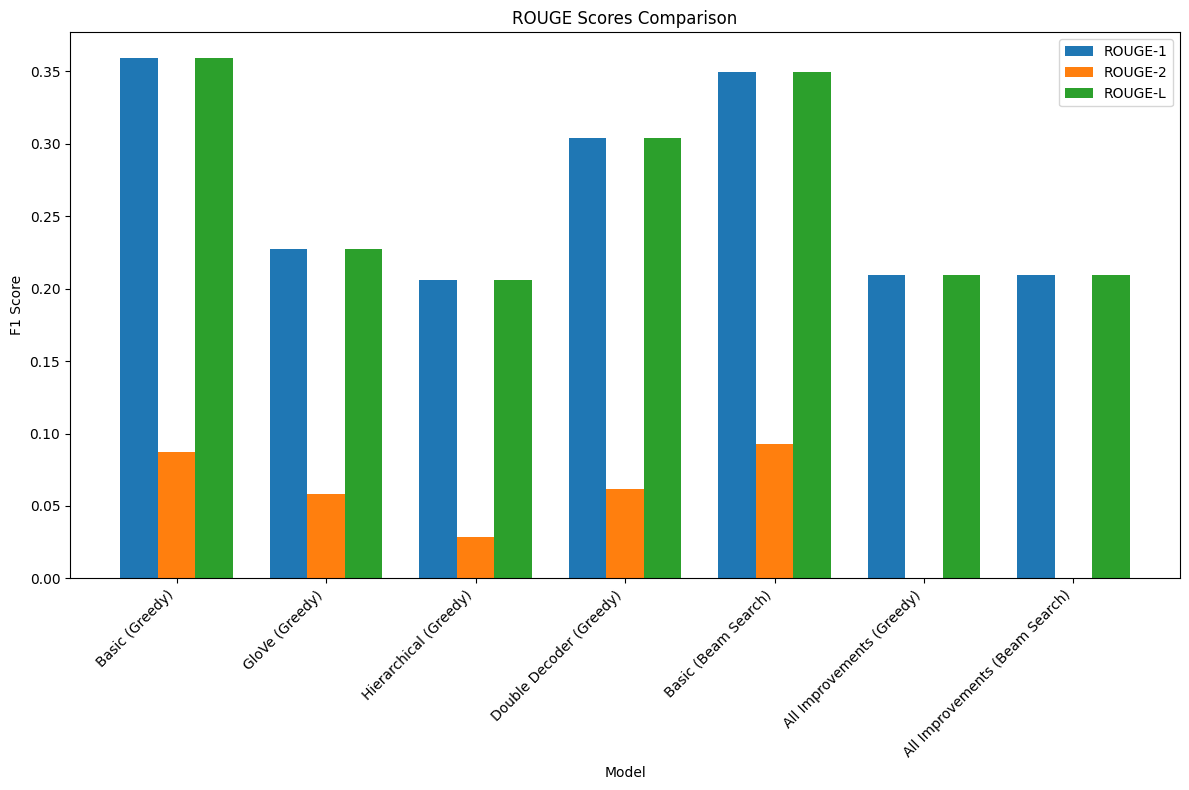

In [95]:
# Plot ROUGE scores comparison
plt.figure(figsize=(12, 8))

x = np.arange(len(results_dict['Model']))
width = 0.25

plt.bar(x - width, results_dict['ROUGE-1'], width, label='ROUGE-1')
plt.bar(x, results_dict['ROUGE-2'], width, label='ROUGE-2')
plt.bar(x + width, results_dict['ROUGE-L'], width, label='ROUGE-L')

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('ROUGE Scores Comparison')
plt.xticks(x, results_dict['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('rouge_scores_comparison.png')
plt.show()

